In [1]:
%pylab inline

from easy_plot import easy_plot

import scipy.ndimage as ndi
from scipy.signal import fftconvolve

%load_ext autoreload
%autoreload 2
from pyotf.otf import SheppardPSF, HanserPSF
from pyotf.microscope import ConfocalMicroscope
from pyotf.utils import easy_fft, easy_ifft
import dphplotting as dplt
from dphutils import bin_ndarray, radial_profile

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.set_cmap("inferno");

<Figure size 432x288 with 0 Axes>

## Apotome

The technology behind the [Zeiss Apotome](https://www.zeiss.com/microscopy/us/products/imaging-systems/apotome-2-for-biology.html) was described by [Neil](https://www.osapublishing.org/abstract.cfm?URI=ol-22-24-1905) and [Wilson](http://www.sciencedirect.com/science/article/pii/S0030401898002107) over 20 years ago. While the math in the papers is opaque and difficult to understand the result can be summarized as follows: the Apotome PSF can be approximated as a light sheet PSF where the width of the light sheet is similar to the axial resolution of microscope and the axial profile is proportional to $J_1(z) / z$. Looking at the second publication the magic all happens in equation 6 where the substitution $S_1(t_1) \sim \exp(j\nu t_1)$ is made (which I still don't understand). The result of this substitution is that the axial response of the system can be written as

$$
I_p(u) = |g(u, \nu)|
$$

Where $g$ is a weird hybrid OTF where the axial dimension is real space and the lateral dimension in k space and $u$ is the normalized axial dimension, $u = 8(\pi / \lambda) z \sin^2(\alpha / 2)$ and $\nu = f \lambda / NA$ where $NA = n \sin (\alpha)$ and $f$ is the actual frequency of the grid. Therefore, the total PSF can be written as

$$
PSF_{total}(\mathbf{r}) = PSF_{epi}(\mathbf{r}) \times I_p(z)
$$

The authors mention, briefly mention that this approximation is only valid in the weak interaction limit. Let's see how well it holds up by simulating the approximate OTF and then simulating the complete image formation and reconstruction process. We can also compare to the confocal PSF as well.

We can proceed with the simulation as before.

In [3]:
# We'll use a 1.27 NA water dipping objective imaging in water
psf_params = dict(
    na=1.27,
    ni=1.33,
    wl=0.561,
    size=64,
    vec_corr="none"
)

# Set the Nyquist sampling rate
nyquist_sampling = psf_params["wl"] / psf_params["na"] / 4

# our oversampling factor, must be odd for easy integration (for peaked symmetrical funtions the kernel must be odd)
oversample_factor = 4

# Over sample to 
psf_params["res"] = nyquist_sampling * 0.99 / oversample_factor
psf_params["size"] *= oversample_factor

In [4]:
# calculate 3D, using Hanser here because it conserves energy axially.
psf_det = HanserPSF(**psf_params).PSFi

### Weird OTF

First let's calculate our "weird" hybrid OTF. It's simple enough, we just need to take the Fourier transform in the lateral dimensions.

In [5]:
# for compatibility with our `easy_plot` function we Fourier transform only the axial dimension.
otf_plot = easy_fft(psf_det, axes=(0,))
otf = easy_ifft(otf_plot)

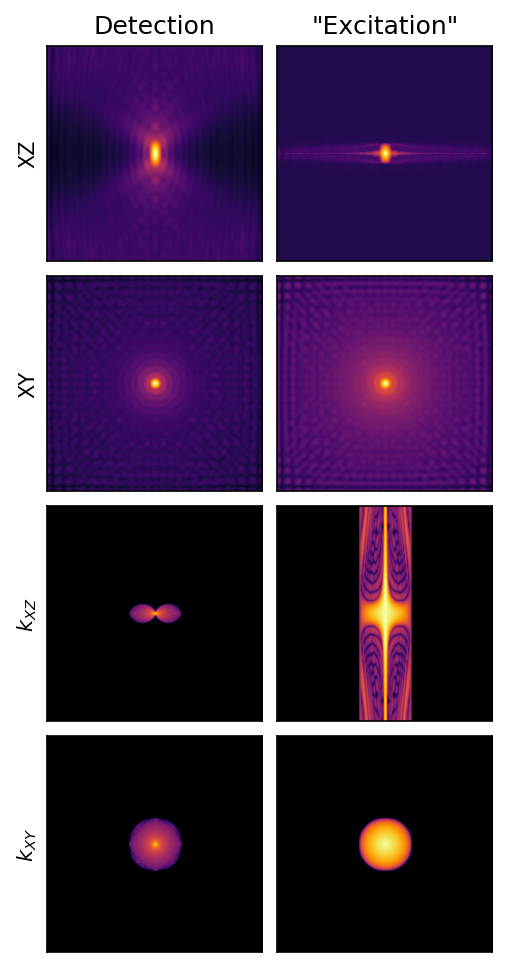

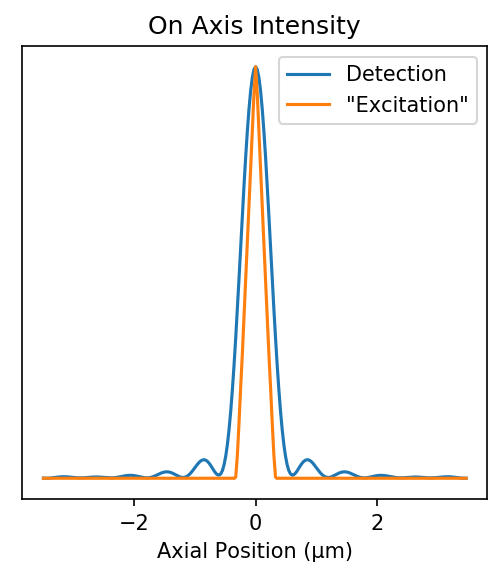

In [6]:
easy_plot((psf_det, otf_plot.real), ("Detection", '"Excitation"'), oversample_factor=1, res=psf_params["res"])

In [7]:
# we only need the radial and axial components
rotf = np.array([radial_profile(o)[0] for o in otf])
rotf /= rotf.max()
rotf = abs(rotf)

Text(0.5, 0, 'Spatial Frequency (2NA/$\\lambda$ µm$^{-1}$)')

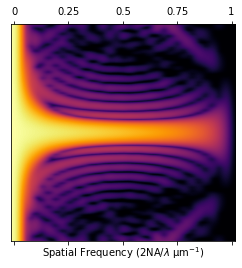

In [8]:
# let's calculate the abbe cutoff
abbe_limit = int(np.rint(psf_params["size"] * psf_params["res"] / nyquist_sampling / 2))
# and plot the results
fig, ax = plt.subplots()
ax.matshow(np.fmax(1e-3, rotf[:,:abbe_limit + 1]), norm=mpl.colors.LogNorm(), interpolation="bicubic")
ax.set_aspect(abbe_limit/len(rotf))
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.MultipleLocator(abbe_limit / 4))
ax.xaxis.set_major_formatter(plt.FixedFormatter([-1/4, 0, 1/4, 1/2, 3/4, 1]))
ax.set_xlabel("Spatial Frequency (2NA/$\lambda$ µm$^{-1}$)")

We find that maximum optical sectioning is at a frequency of half the abbe limit (an appeal to SIM will show that this is most effective at filling in the missing cone).

In fact, as stated in the papter, we get _zero_ optical sectioning at the max and min (0) spatial frequencies.

In [9]:
# our approximate PSF is the detection PSF multiplied by our approximate axial response
axial_profile = rotf[:, abbe_limit//2]
psf_apo = psf_det * axial_profile[:, None, None]

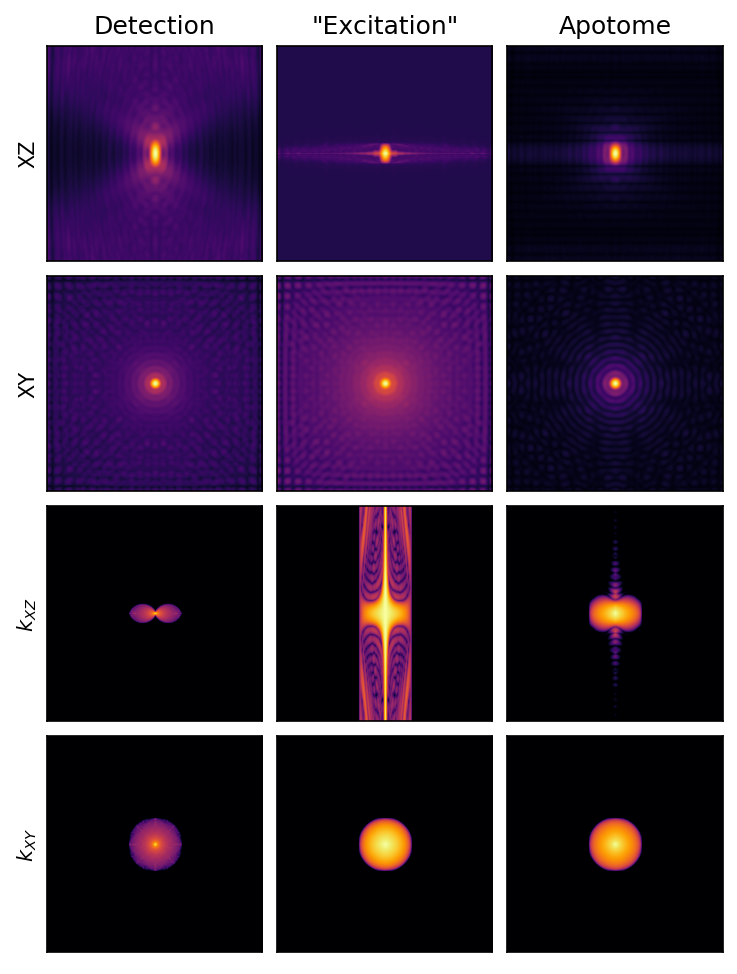

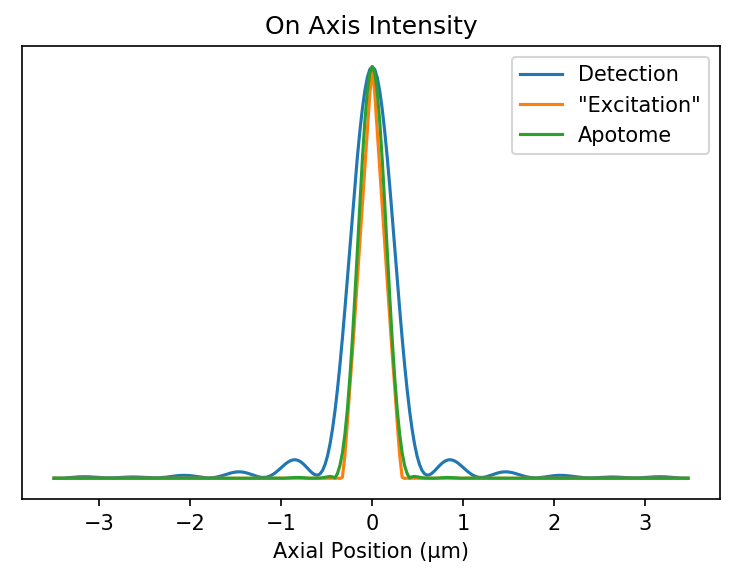

In [10]:
easy_plot((psf_det, otf_plot.real, psf_apo), ("Detection", '"Excitation"', "Apotome"),
          1, psf_params["res"])

### Straight simulation

How does the approximation fare when compared to an exact simulation of the image formation process and computational processing? Let's take a look.

In [11]:
# generate a set of random points on our high res grid.
np.random.seed(12345)
sim_volume = np.random.binomial(1.0, size=psf_det.shape, p=0.0001 * 2 / oversample_factor )

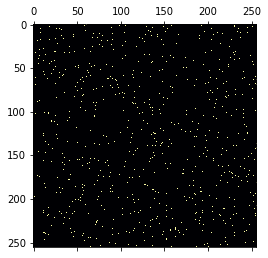

In [12]:
matshow(sim_volume.max(0))

Text(0.5, 0, 'Lateral Dimension (µm)')

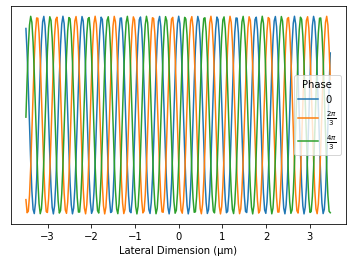

In [13]:
# generate our 1D grid at the appropriate resolution
num_pixels = len(psf_det)
x = np.arange(num_pixels) * 1.0 - (num_pixels + 1) // 2
x *= psf_params["res"]
# Calculate our Abbe Frequency (double Nyquist)
abbe_frequency = 1 / nyquist_sampling / 2
# Generate our excitation patterns at three phases at half the Abbe frequency for best sectioning
excs = [0.5 + 0.5 * cos(2 * pi * abbe_frequency * x / 2 + phi) for phi in (0, 2 * pi / 3, 4 * pi / 3)]

# Plot
fig, ax = plt.subplots()
for l, exc in zip(("0", r"$\frac{2 \pi}{3}$", r"$\frac{4 \pi}{3}$"), excs):
    ax.plot(x, exc, label=l)
ax.legend(title="Phase")
ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_xlabel("Lateral Dimension (µm)")

In [14]:
# multiply the sample by the excitation pattern (thanks numpy broadcasting!)
# and then simulate the image by convolving with the PSF
%time sim_volume_blurs = [fftconvolve(sim_volume * exc[None, :, None], psf_det, "same") for exc in excs]

CPU times: user 24.5 s, sys: 7.56 s, total: 32 s
Wall time: 32.2 s


In [15]:
# Calculate the conventional image
conv = np.mean(sim_volume_blurs, axis=0)
# break out the blurred volumes
I1, I2, I3 = sim_volume_blurs
# calculate the apotome image
apo = sqrt(2) / 3 * sqrt((I1 - I2) ** 2 + (I1 - I3) ** 2 + (I2 - I3) ** 2)

In [16]:
# calculate the approximate apotome image
apo_approx = fftconvolve(sim_volume, psf_apo, "same")

In [17]:
# for comparison generate a confocal image with a pinhole that's 1.5AU
%time psf_con = ConfocalMicroscope(model="hanser", pixel_size=psf_params["res"], oversample_factor=1, **psf_params, wl_exc=psf_params["wl"], pinhole_size=1.5).PSF

CPU times: user 3.03 s, sys: 1.37 s, total: 4.4 s
Wall time: 4.43 s


In [18]:
%time confocal = fftconvolve(sim_volume, psf_con, "same")

CPU times: user 8.38 s, sys: 2.45 s, total: 10.8 s
Wall time: 10.9 s


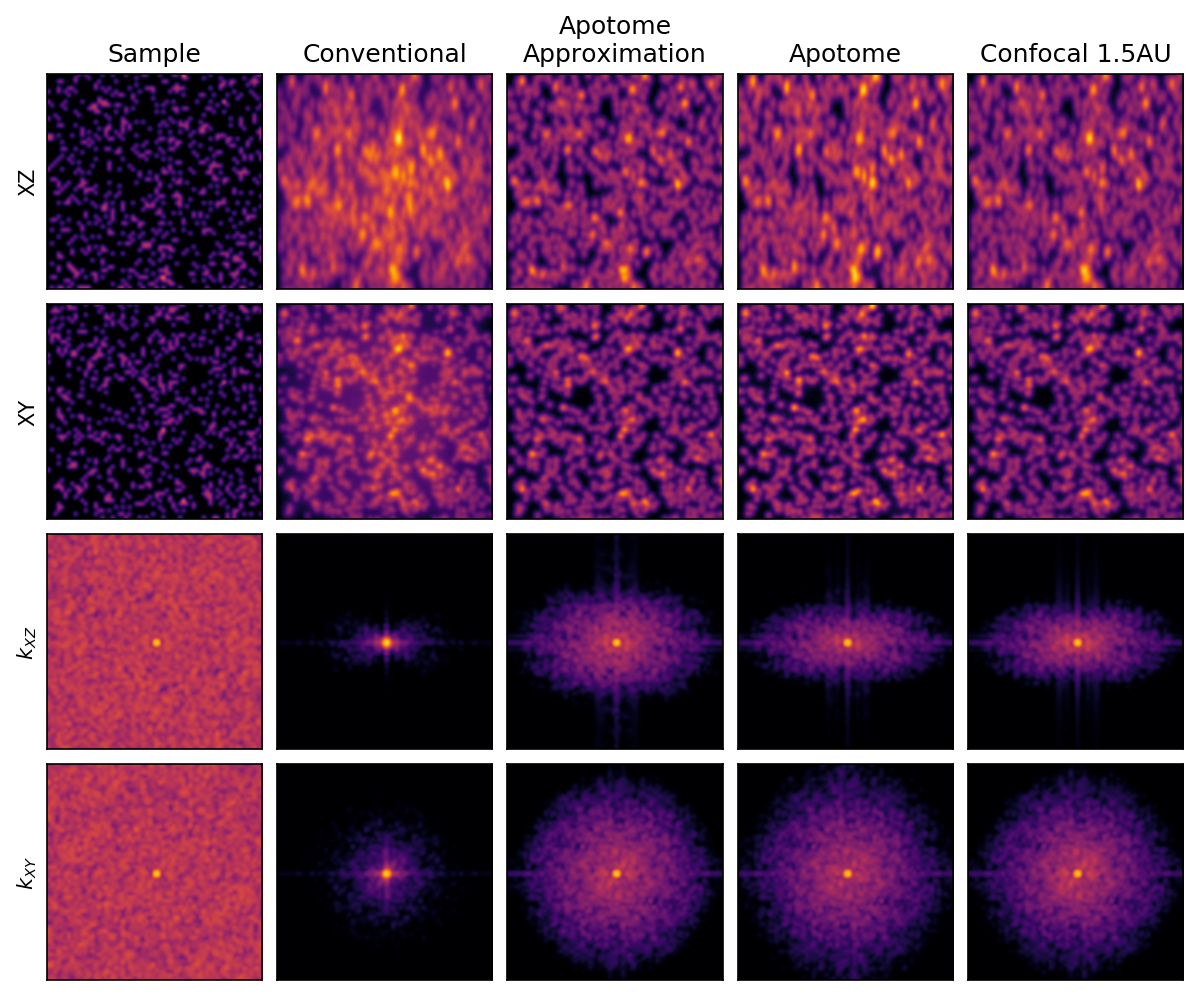

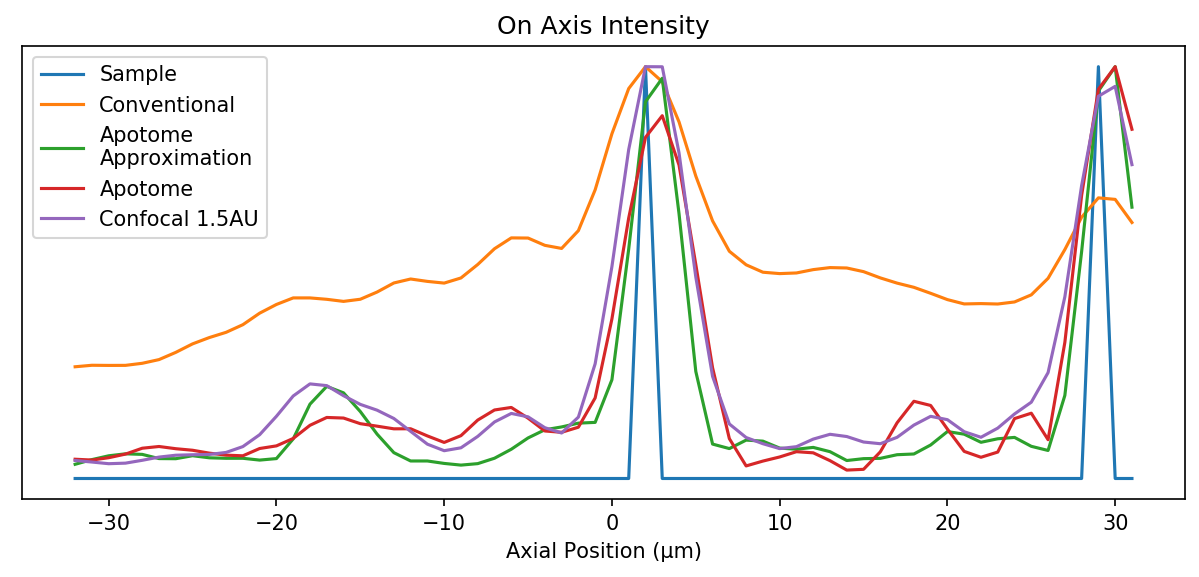

In [19]:
easy_plot(
    (sim_volume * 1.0, conv, apo_approx, apo, confocal),
    ("Sample", "Conventional", "Apotome\nApproximation", "Apotome", "Confocal 1.5AU"),
    oversample_factor=oversample_factor, gam=1)

The apotome approximation seems to grossly overestimate the axial resolution and optical sectioning abilities of the Apotome microscope. A much better approximation is that of a confocal microscope with a pinhole size of 1.5 AU. It's important to note that because the produces images in a non-linear fashion the resulting images cannot be deconvolved using the usual techniques as those assume a spatially invariant linear PSF model, i.e. that the image formation model can be represented as a convolution.

In [20]:
from pyotf.microscope import ApotomeMicroscope

In [24]:
psf_apo2 = ApotomeMicroscope(model="hanser", pixel_size=psf_params["res"], oversample_factor=1, **psf_params).PSF

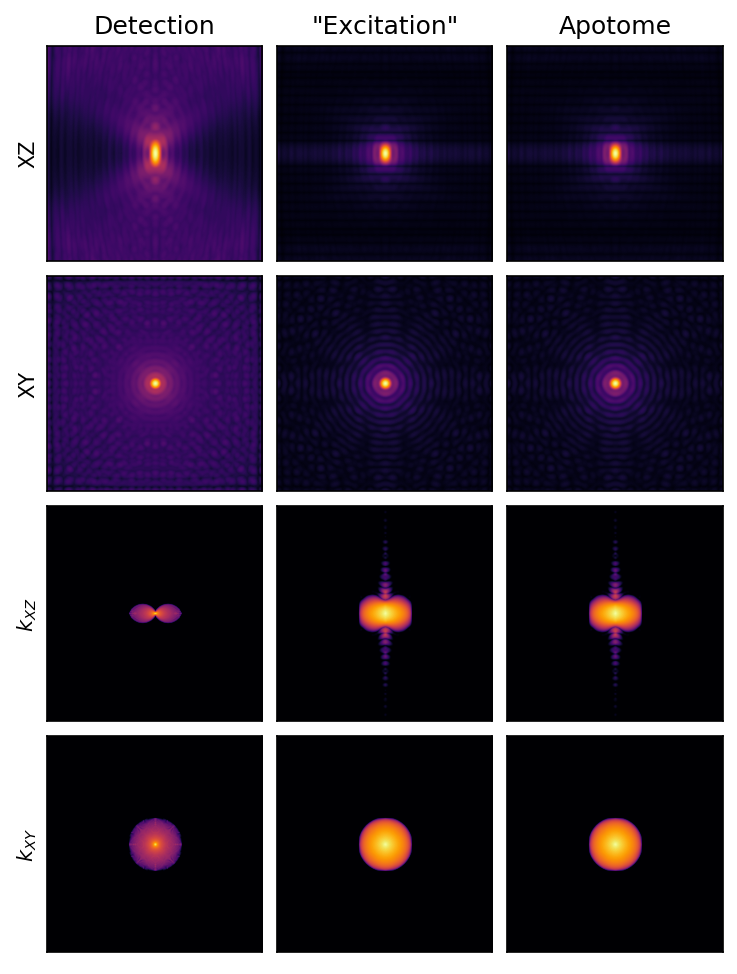

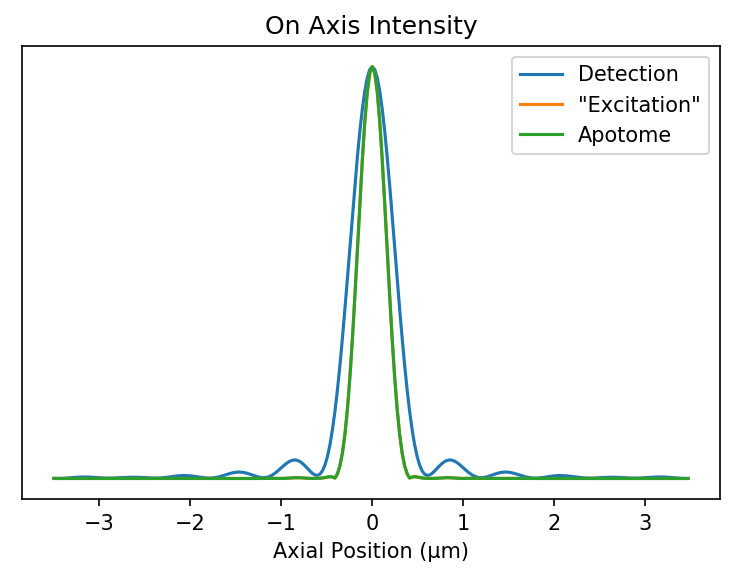

In [25]:
easy_plot((psf_det, psf_apo2, psf_apo), ("Detection", '"Excitation"', "Apotome"),
          1, psf_params["res"])